# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=55,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 55)
OOV context shape: (16562, 28)
Right context shape: (16562, 55)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[-6.1108802e-27,  4.5650100e-41, -6.1108802e-27, ...,
         4.5650100e-41,  1.3638934e-36,  4.5650100e-41],
       [ 1.0882344e-40,  0.0000000e+00,  3.6886122e-37, ...,
         0.0000000e+00,  3.6886839e-37,  4.5650100e-41],
       [ 1.3639623e-36,  4.5650100e-41,  1.0883885e-40, ...,
         4.5650100e-41,  1.0885286e-40,  0.0000000e+00],
       ...,
       [ 1.3717741e-36,  4.5650100e-41,  1.1057086e-40, ...,
         4.5650100e-41,  1.1058487e-40,  0.0000000e+00],
       [ 5.3499288e-38,  4.5650100e-41,  1.3718372e-36, ...,
         4.5650100e-41,  1.3718946e-36,  4.5650100e-41],
       [ 1.1060028e-40,  0.0000000e+00,  5.3501261e-38, ...,
         0.0000000e+00,  5.3503055e-38,  4.5650100e-41]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=6.6898 | F1Score=0.2831
Batch-100: NLLLoss=5.7229 | F1Score=0.3097
Batch-150: NLLLoss=5.7369 | F1Score=0.3306
Batch-200: NLLLoss=4.4095 | F1Score=0.3500
Batch-250: NLLLoss=3.8921 | F1Score=0.3717
Batch-300: NLLLoss=4.4559 | F1Score=0.3844
Batch-350: NLLLoss=4.4180 | F1Score=0.3978
Batch-400: NLLLoss=3.0422 | F1Score=0.4092
Batch-450: NLLLoss=4.0458 | F1Score=0.4211
Batch-500: NLLLoss=2.1492 | F1Score=0.4328
Batch-518: NLLLoss=4.7859 | F1Score=0.4369

Mean NLLLoss: 4.5272 | Mean F1Score: 0.3571

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.8761 | F1Score=0.5900
Batch-100: NLLLoss=2.3925 | F1Score=0.5947
Batch-150: NLLLoss=2.6063 | F1Score=0.5890
Batch-200: NLLLoss=2.7851 | F1Score=0.5991
Batch-250: NLLLoss=3.3482 | F1Score=0.6072
Batch-300: NLLLoss=2.3620 | F1Score=0.6193
Batch-350: NLLLoss=2.1349 | F1Score=0.6231
Batch-400: NLLLoss=2.5970 | F1Score=0.6279
Batch-450: NLLLoss=2.1390 | F1Score=0.6328
Batch-500: NLLLoss=1.8613 | F1Score=0.6363
Batch-518: NLLLoss=2.8440 | F1Score=0.6387

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.7032 | Mean F1Score: 0.6087

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.1285 | F1Score=0.7300
Batch-100: NLLLoss=1.6368 | F1Score=0.7322
Batch-150: NLLLoss=1.7694 | F1Score=0.7238
Batch-200: NLLLoss=2.8020 | F1Score=0.7293
Batch-250: NLLLoss=1.8479 | F1Score=0.7274
Batch-300: NLLLoss=2.2908 | F1Score=0.7273
Batch-350: NLLLoss=1.6132 | F1Score=0.7290
Batch-400: NLLLoss=1.4833 | F1Score=0.7352
Batch-450: NLLLoss=0.5174 | F1Score=0.7404
Batch-500: NLLLoss=2.0886 | F1Score=0.7430
Batch-518: NLLLoss=2.0708 | F1Score=0.7440

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7863 | Mean F1Score: 0.7325

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.5221 | F1Score=0.8231
Batch-100: NLLLoss=1.4136 | F1Score=0.8147
Batch-150: NLLLoss=1.0058 | F1Score=0.8169
Batch-200: NLLLoss=1.2895 | F1Score=0.8148
Batch-250: NLLLoss=0.9902 | F1Score=0.8145
Batch-300: NLLLoss=1.4562 | F1Score=0.8162
Batch-350: NLLLoss=0.8650 | F1Score=0.8156
Batch-400: NLLLoss=1.3459 | F1Score=0.8163
Batch-450: NLLLoss=0.9655 | F1Score=0.8187
Batch-500: NLLLoss=1.1633 | F1Score=0.8179
Batch-518: NLLLoss=0.9565 | F1Score=0.8176

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1601 | Mean F1Score: 0.8182

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.7781 | F1Score=0.8869
Batch-100: NLLLoss=0.7336 | F1Score=0.8866
Batch-150: NLLLoss=1.0223 | F1Score=0.8834
Batch-200: NLLLoss=0.6934 | F1Score=0.8801
Batch-250: NLLLoss=0.4934 | F1Score=0.8801
Batch-300: NLLLoss=0.5678 | F1Score=0.8780
Batch-350: NLLLoss=0.5300 | F1Score=0.8748
Batch-400: NLLLoss=0.5632 | F1Score=0.8735
Batch-450: NLLLoss=1.1457 | F1Score=0.8743
Batch-500: NLLLoss=0.2405 | F1Score=0.8749
Batch-518: NLLLoss=1.2864 | F1Score=0.8745

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6915 | Mean F1Score: 0.8781

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.5446 | F1Score=0.9488
Batch-100: NLLLoss=0.1697 | F1Score=0.9478
Batch-150: NLLLoss=0.2215 | F1Score=0.9467
Batch-200: NLLLoss=0.3147 | F1Score=0.9468
Batch-250: NLLLoss=0.4385 | F1Score=0.9459
Batch-300: NLLLoss=0.2305 | F1Score=0.9424
Batch-350: NLLLoss=0.4862 | F1Score=0.9408
Batch-400: NLLLoss=0.2013 | F1Score=0.9399
Batch-450: NLLLoss=0.3517 | F1Score=0.9393
Batch-500: NLLLoss=0.2968 | F1Score=0.9377
Batch-518: NLLLoss=0.6110 | F1Score=0.9371

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3431 | Mean F1Score: 0.9447

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1828 | F1Score=0.9919
Batch-100: NLLLoss=0.0255 | F1Score=0.9925
Batch-150: NLLLoss=0.2095 | F1Score=0.9928
Batch-200: NLLLoss=0.0240 | F1Score=0.9913
Batch-250: NLLLoss=0.0840 | F1Score=0.9902
Batch-300: NLLLoss=0.1404 | F1Score=0.9899
Batch-350: NLLLoss=0.2597 | F1Score=0.9896
Batch-400: NLLLoss=0.2111 | F1Score=0.9883
Batch-450: NLLLoss=0.0698 | F1Score=0.9879
Batch-500: NLLLoss=0.0290 | F1Score=0.9876
Batch-518: NLLLoss=0.2910 | F1Score=0.9872

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1144 | Mean F1Score: 0.9905

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0187 | F1Score=0.9994
Batch-100: NLLLoss=0.0254 | F1Score=0.9991
Batch-150: NLLLoss=0.0821 | F1Score=0.9994
Batch-200: NLLLoss=0.0141 | F1Score=0.9988
Batch-250: NLLLoss=0.0227 | F1Score=0.9989
Batch-300: NLLLoss=0.0223 | F1Score=0.9991
Batch-350: NLLLoss=0.0239 | F1Score=0.9991
Batch-400: NLLLoss=0.0508 | F1Score=0.9992
Batch-450: NLLLoss=0.0318 | F1Score=0.9991
Batch-500: NLLLoss=0.0251 | F1Score=0.9989
Batch-518: NLLLoss=0.0276 | F1Score=0.9990

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0286 | Mean F1Score: 0.9991

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0063 | F1Score=0.9997
Batch-100: NLLLoss=0.0166 | F1Score=0.9998
Batch-150: NLLLoss=0.0127 | F1Score=0.9995
Batch-200: NLLLoss=0.0170 | F1Score=0.9994
Batch-250: NLLLoss=0.0168 | F1Score=0.9995
Batch-300: NLLLoss=0.0173 | F1Score=0.9996
Batch-350: NLLLoss=0.0050 | F1Score=0.9996
Batch-400: NLLLoss=0.0102 | F1Score=0.9995
Batch-450: NLLLoss=0.0304 | F1Score=0.9995
Batch-500: NLLLoss=0.0086 | F1Score=0.9995
Batch-518: NLLLoss=0.0084 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0105 | Mean F1Score: 0.9995

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0077 | F1Score=0.9994
Batch-100: NLLLoss=0.0059 | F1Score=0.9987
Batch-150: NLLLoss=0.1637 | F1Score=0.9990
Batch-200: NLLLoss=0.0067 | F1Score=0.9990
Batch-250: NLLLoss=0.0069 | F1Score=0.9992
Batch-300: NLLLoss=0.0035 | F1Score=0.9993
Batch-350: NLLLoss=0.0077 | F1Score=0.9993
Batch-400: NLLLoss=0.0050 | F1Score=0.9994
Batch-450: NLLLoss=0.0056 | F1Score=0.9995
Batch-500: NLLLoss=0.0035 | F1Score=0.9995
Batch-518: NLLLoss=0.0035 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0076 | Mean F1Score: 0.9992

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0044 | F1Score=1.0000
Batch-100: NLLLoss=0.0025 | F1Score=1.0000
Batch-150: NLLLoss=0.0025 | F1Score=0.9999
Batch-200: NLLLoss=0.0041 | F1Score=0.9998
Batch-250: NLLLoss=0.0038 | F1Score=0.9999
Batch-300: NLLLoss=0.0034 | F1Score=0.9999
Batch-350: NLLLoss=0.0036 | F1Score=0.9999
Batch-400: NLLLoss=0.0031 | F1Score=0.9998
Batch-450: NLLLoss=0.0018 | F1Score=0.9998
Batch-500: NLLLoss=0.0047 | F1Score=0.9997
Batch-518: NLLLoss=0.0035 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0048 | Mean F1Score: 0.9999

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0035 | F1Score=0.9997
Batch-100: NLLLoss=0.0029 | F1Score=0.9998
Batch-150: NLLLoss=0.0025 | F1Score=0.9999
Batch-200: NLLLoss=0.0039 | F1Score=0.9998
Batch-250: NLLLoss=0.0024 | F1Score=0.9999
Batch-300: NLLLoss=0.0011 | F1Score=0.9999
Batch-350: NLLLoss=0.0029 | F1Score=0.9998
Batch-400: NLLLoss=0.0039 | F1Score=0.9996
Batch-450: NLLLoss=0.0099 | F1Score=0.9994
Batch-500: NLLLoss=0.0043 | F1Score=0.9995
Batch-518: NLLLoss=0.0028 | F1Score=0.9995

Huft 😥! Model not improved.
Mean NLLLoss: 0.0058 | Mean F1Score: 0.9997
Patience = 1/20❗

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.2077 | F1Score=0.9984
Batch-100: NLLLoss=0.0069 | F1Score=0.9989
Batch-150: NLLLoss=0.0029 | F1Score=0.9989
Batch-200: NLLLoss=0.0074 | F1Score=0.9991
Batch-250: NLLLoss=0.0040 | F1Score=0.9992
Batch-300: NLLLoss=0.0075 | F1Score=0.9993
Batch-350: NLLLoss=0.0041 | F1Score=0.9994
Batch-400: NLLLoss=0.0158 | F1Score=0.9995
Batch-450: NLLLoss=0.0399 | F1Score=0.9994
Batch-500: NLLLoss=0.7900 | F1Score=0.9912
Batch-518: NLLLoss=0.5055 | F1Score=0.9876

Huft 😥! Model not improved.
Mean NLLLoss: 0.0594 | Mean F1Score: 0.9986
Patience = 2/20❗

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.7197 | F1Score=0.8865
Batch-100: NLLLoss=0.4517 | F1Score=0.9064
Batch-150: NLLLoss=0.2416 | F1Score=0.9118
Batch-200: NLLLoss=0.2324 | F1Score=0.9234
Batch-250: NLLLoss=0.1667 | F1Score=0.9281
Batch-300: NLLLoss=0.2671 | F1Score=0.9322
Batch-350: NLLLoss=0.0958 | F1Score=0.9367
Batch-400: NLLLoss=0.0954 | F1Score=0.9387
Batch-450: NLLLoss=0.0715 | F1Score=0.9408
Batch-500: NLLLoss=0.0776 | F1Score=0.9435
Batch-518: NLLLoss=0.1189 | F1Score=0.9441

Huft 😥! Model not improved.
Mean NLLLoss: 0.2308 | Mean F1Score: 0.9220
Patience = 3/20❗

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0522 | F1Score=0.9925
Batch-100: NLLLoss=0.0218 | F1Score=0.9934
Batch-150: NLLLoss=0.0079 | F1Score=0.9946
Batch-200: NLLLoss=0.0065 | F1Score=0.9953
Batch-250: NLLLoss=0.0031 | F1Score=0.9962
Batch-300: NLLLoss=0.0097 | F1Score=0.9967
Batch-350: NLLLoss=0.0156 | F1Score=0.9971
Batch-400: NLLLoss=0.0028 | F1Score=0.9974
Batch-450: NLLLoss=0.0304 | F1Score=0.9973
Batch-500: NLLLoss=0.0182 | F1Score=0.9976
Batch-518: NLLLoss=0.0051 | F1Score=0.9976

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0154 | Mean F1Score: 0.9955

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0011 | F1Score=0.9987
Batch-100: NLLLoss=0.0018 | F1Score=0.9994
Batch-150: NLLLoss=0.0017 | F1Score=0.9994
Batch-200: NLLLoss=0.0008 | F1Score=0.9994
Batch-250: NLLLoss=0.0021 | F1Score=0.9995
Batch-300: NLLLoss=0.0018 | F1Score=0.9995
Batch-350: NLLLoss=0.0015 | F1Score=0.9995
Batch-400: NLLLoss=0.0018 | F1Score=0.9995
Batch-450: NLLLoss=0.0015 | F1Score=0.9996
Batch-500: NLLLoss=0.0019 | F1Score=0.9996
Batch-518: NLLLoss=0.0003 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0039 | Mean F1Score: 0.9994

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0021 | F1Score=0.9997
Batch-100: NLLLoss=0.0016 | F1Score=0.9998
Batch-150: NLLLoss=0.0016 | F1Score=0.9999
Batch-200: NLLLoss=0.0020 | F1Score=0.9999
Batch-250: NLLLoss=0.0010 | F1Score=0.9999
Batch-300: NLLLoss=0.0016 | F1Score=0.9998
Batch-350: NLLLoss=0.0013 | F1Score=0.9998
Batch-400: NLLLoss=0.0007 | F1Score=0.9998
Batch-450: NLLLoss=0.0012 | F1Score=0.9998
Batch-500: NLLLoss=0.0005 | F1Score=0.9998
Batch-518: NLLLoss=0.0018 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0015 | Mean F1Score: 0.9998

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0010 | F1Score=0.9997
Batch-100: NLLLoss=0.0007 | F1Score=0.9997
Batch-150: NLLLoss=0.0006 | F1Score=0.9998
Batch-200: NLLLoss=0.0013 | F1Score=0.9998
Batch-250: NLLLoss=0.0015 | F1Score=0.9999
Batch-300: NLLLoss=0.0012 | F1Score=0.9998
Batch-350: NLLLoss=0.0005 | F1Score=0.9998
Batch-400: NLLLoss=0.0008 | F1Score=0.9998
Batch-450: NLLLoss=0.0009 | F1Score=0.9998
Batch-500: NLLLoss=0.0007 | F1Score=0.9998
Batch-518: NLLLoss=0.0013 | F1Score=0.9998

Huft 😥! Model not improved.
Mean NLLLoss: 0.0017 | Mean F1Score: 0.9998
Patience = 4/20❗

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0006 | F1Score=1.0000
Batch-100: NLLLoss=0.0008 | F1Score=1.0000
Batch-150: NLLLoss=0.0011 | F1Score=0.9999
Batch-200: NLLLoss=0.0009 | F1Score=0.9999
Batch-250: NLLLoss=0.0008 | F1Score=0.9998
Batch-300: NLLLoss=0.0009 | F1Score=0.9998
Batch-350: NLLLoss=0.0003 | F1Score=0.9998
Batch-400: NLLLoss=0.0013 | F1Score=0.9998
Batch-450: NLLLoss=0.0010 | F1Score=0.9998
Batch-500: NLLLoss=0.0004 | F1Score=0.9998
Batch-518: NLLLoss=0.0013 | F1Score=0.9998

Huft 😥! Model not improved.
Mean NLLLoss: 0.0018 | Mean F1Score: 0.9999
Patience = 5/20❗

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0007 | F1Score=1.0000
Batch-100: NLLLoss=0.0005 | F1Score=1.0000
Batch-150: NLLLoss=0.0015 | F1Score=0.9997
Batch-200: NLLLoss=0.0006 | F1Score=0.9998
Batch-250: NLLLoss=0.0007 | F1Score=0.9998
Batch-300: NLLLoss=0.0007 | F1Score=0.9998
Batch-350: NLLLoss=0.0007 | F1Score=0.9998
Batch-400: NLLLoss=0.0006 | F1Score=0.9998
Batch-450: NLLLoss=0.0003 | F1Score=0.9998
Batch-500: NLLLoss=0.0006 | F1Score=0.9997
Batch-518: NLLLoss=0.0551 | F1Score=0.9997

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0012 | Mean F1Score: 0.9998

TRAINING SUMMARY
Best NLLLoss      : 0.0012
Best F1Score      : 0.9998
Training duration : 27.812 minutes.
Training date     : 2022-10-11 16:08:07.936452+08:00


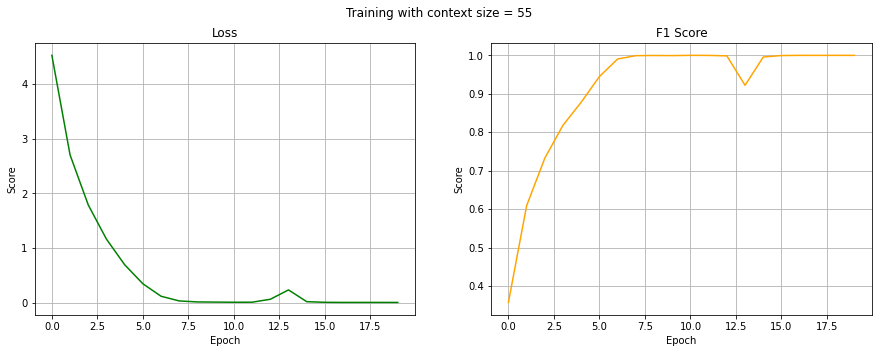

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[ 2.9572573 , -5.9895067 ,  3.704153  , ..., -2.425081  ,
         3.764498  , -0.8828489 ],
       [ 4.25791   ,  3.4694314 ,  0.22771212, ...,  6.2428083 ,
        -3.4105866 , -3.8448215 ],
       [ 3.9319263 ,  0.05847259,  2.3278463 , ..., -1.0264643 ,
        -2.3846827 , -6.9776335 ],
       ...,
       [-1.9927524 ,  0.5046115 , -0.1078063 , ...,  2.4813058 ,
        -1.417194  , -0.44834864],
       [-3.2021124 ,  6.7845936 , -3.3111973 , ..., -5.5867867 ,
        -0.23915544, -0.8035184 ],
       [ 5.5569854 ,  0.95947134,  3.4284139 , ..., -2.3504224 ,
         1.7967895 , -1.6850154 ]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[ 0.0994, -0.2944, -0.1384,  ..., -0.1281,  0.2891, -0.5773],
                      [-0.0105, -0.0801, -0.0848,  ..., -0.2761, -0.0561, -0.2048],
                      [ 0.0965, -0.2513,  0.0817,  ..., -0.1375,  0.0499, -0.2135],
                      ...,
                      [ 0.2852, -0.2841, -0.0708,  ..., -0.0554, -0.1704, -0.0486],
                      [ 0.0816,  0.0260, -0.0069,  ..., -0.2999,  0.0531, -0.1345],
                      [ 0.1332, -0.3470, -0.0159,  ..., -0.4874,  0.0090, -0.1769]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[-0.1329,  0.1957,  0.0161,  ..., -0.2849,  0.1471,  0.0172],
                      [ 0.1092,  0.1125, -0.0512,  ...,  0.0329,  0.1109,  0.2373],
                      [-0.0173, -0.0354, -0.2383,  ..., -0.1559,  0.2220,  0.0297],
                      ...,
                      [-0.2955, -0.0481,  0.0063,  ..., -0.1221,  0.002